# Cogs 118C, Spring 2020


## HW5

Name: Malachi Mabie

Student ID: A15737533

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal

# 1. Time-frequency analysis

In [2]:
data = np.loadtxt('HW5_anesthesia_record_125Hz.csv',delimiter=',')#pd.read_csv("HW5_anesthesia_record_125Hz.csv",header=None).T
Fs = 125 #hz
# this dataset contains 50min (3000s) of EEG recording during induction of anesthesia.
# first ~1000s: awake, afterwards losing consciousness with increasing doses of drug. Sampled at 125 Hz.
print(data)

[ 1.3684  3.8323  3.5829 ... -7.5338 -8.3347 -2.8712]


In [3]:
# a) calculate short-time Fourier transform. Windows of length 2s with no overlap. Else is default.
time_window = 2
f,t,S = scipy.signal.stft(data,fs=Fs, nperseg=time_window*Fs, noverlap=0) #nperseg = length per segment,
# defaults to 256 frames. We want the equivalent of 2 seconds.

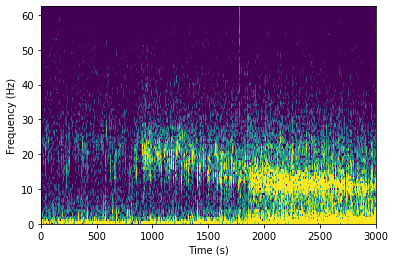

In [4]:
# b) calculate the log of the spectral power, then form colormap plot of it.
log_spectral_power = np.log10(abs(S)**2)

plt.pcolormesh(t, f, log_spectral_power, vmin=-1.9, vmax=2*np.sqrt(1/Fs))

plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.show()

#### c) What peaks do you notice in the power spectrum, and how do they change over time during the recording? What conclusions can you draw about the effect of general anesthesia with propofol on oscillations in the human brain?
    Ignoring the very low frequency, we see a 13-25 Hz band for the second 2/3 of the signal, with a more
    concentrated 8-15Hz band for the last 1/3 of the signal. It appears that these concentrations coincide with a first and second dose of propofol.

In [5]:
#d) What is the frequency resolutio of this spectrogram?
freq_res = 1/time_window
print("frequency resolution = ", freq_res, "Hz")

frequency resolution =  0.5 Hz


#### e) How would need to modify your calculation to achieve a finer resolution of 0.1 Hz?
    The time window would have to be 10 seconds in order for that to happen.

# 2. Deconvolution

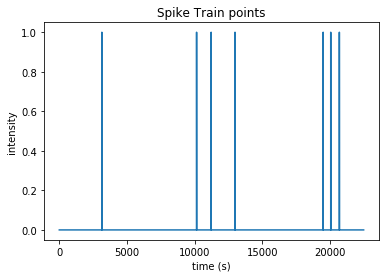

In [6]:
# a) Simulate a spike train of duration T=15 s, sampled at Fs=1.5 kHz. p(spike)=.05%.
#    Plot the resulting spike train.
T = 15 #secs
Fs_spike = int(1.5*1000) # 1.5 kHz
num_samples = T*Fs_spike
p = .0005
spike_train = np.random.choice(2, size=num_samples, p=[1-p,p])

plt.plot(spike_train)
plt.title("Spike Train points")
plt.xlabel("time (s)")
plt.ylabel("intensity")
plt.show()

Text(0, 0.5, 'intensity')

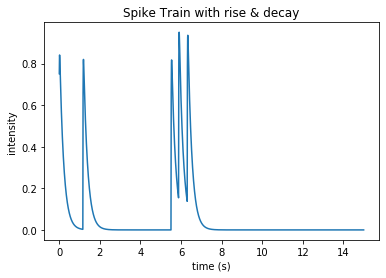

In [7]:
# b) convolve with rise and decay time
tau1 = .01
tau2 = .2
t = np.arange(0, T, 1/Fs_spike)
# impulse response function & heaviside
h = np.heaviside(t,1)*(1-np.exp(-t/tau1))*np.exp(-t/tau2)
# convolve with spike train
st_conv = scipy.signal.convolve(spike_train, h, 'same')

plt.plot(t, st_conv)
plt.title("Spike Train with rise & decay")
plt.xlabel("time (s)")
plt.ylabel("intensity")

Text(0, 0.5, 'intensity')

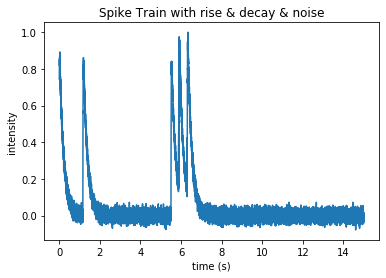

In [8]:
# c) Add Gaussian white noise of rms amplitude 0.02 to signal
noise = np.random.normal(0,.02, st_conv.shape)
st_conv_noise = st_conv + noise
plt.plot(t, st_conv_noise)
plt.title("Spike Train with rise & decay & noise")
plt.xlabel("time (s)")
plt.ylabel("intensity")

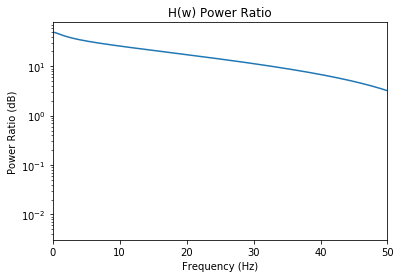

In [9]:
# d) Use fft to calculate the transfer function
# and plot the “power ratio” in decibels
# as a function of frequency from 0 to 50 Hz.
# The power ratio is the ratio of the output to the input power.

transfer = np.abs(np.fft.fft(h))**2

freqs = np.fft.fftfreq(len(st_conv), 1/Fs_spike)
transfer_dB = 10*np.log10(transfer)

plt.semilogy(freqs,transfer_dB)

plt.title("H(w) Power Ratio")
plt.ylabel("Power Ratio (dB)")
plt.xlim(0,50)
plt.xlabel("Frequency (Hz)")
plt.show()

Text(0, 0.5, 'magnitude (dB)')

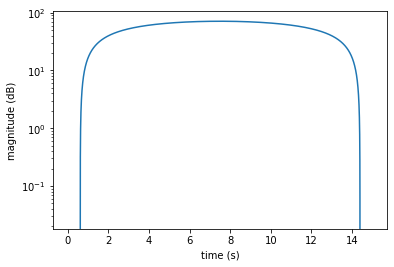

In [10]:
# e) Deconvolution as LTI operation:
# Plot magnitude of deconvolved transfer function
#for the calcium impulse response, in dB
deconvolve = 1 / transfer
deconvolve_mag = np.abs(deconvolve)**2
deconvolve_dB = 10*np.log10(deconvolve_mag)
plt.semilogy(t, deconvolve_dB)
plt.xlabel("time (s)")
plt.ylabel("magnitude (dB)")


/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


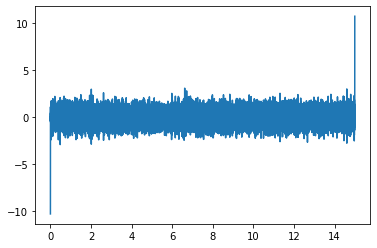

In [11]:
# f) Deconvolve noisy signal from (c) & plot
Hw = np.fft.fft(h)
Yw = np.fft.fft(st_conv_noise)
plt.plot(t, np.fft.ifft(Yw/Hw)) # divide out the decay function